# fbprophet 모델을 활용한 인공지능 비트 트레이더 경진대회 베이스라인 코드

In [1]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive

/content/gdrive/MyDrive


In [3]:
ls | grep ModuWay

ModuWay/


# 1. Library Import

In [4]:
!pip install statsmodels==0.11.1
!pip install fbprophet

     |████████████████████████████████| 8.7MB 4.0MB/s 
  Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [5]:
import numpy as np
import pandas as pd
import gc
import math
import os.path
import time
import matplotlib.pyplot as plt
from datetime import timedelta, datetime
from dateutil import parser
from tqdm import tqdm
import copy
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from fbprophet import Prophet
import warnings
import datetime
warnings.filterwarnings("ignore")

# 2. 데이터 불러오기

## 1) read_csv

In [7]:
os.getcwd()

'/content/gdrive/MyDrive'

In [8]:
data_path = os.getcwd()+ '/ModuWay/data'
train_x_df = pd.read_csv(data_path  + "/train_x_df.csv")
train_y_df = pd.read_csv(data_path  + "/train_y_df.csv")
test_x_df = pd.read_csv(data_path  + "/test_x_df.csv")

## 2) numpy arrary로 변환하기

In [13]:
def df2d_to_array3d(df_2d):
    # 입력 받은 2차원 데이터 프레임을 3차원 numpy array로 변경하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    print(feature_size, time_size, sample_size)
    sample_index = df_2d.sample_id.value_counts().index
    print(sample_index)
    array_3d = df_2d.iloc[:,2:].values.reshape([sample_size, time_size, feature_size])
    return array_3d

In [14]:
print(train_x_df.shape)
# print(train_x_df.iloc[:, 2:].shape[1])
# print(train_x_df.sample_id.value_counts().index)
train_x_df.head()

(10159560, 12)


,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
0,0,0,7,1.010004,1.010004,1.009612,1.010004,8.382875e+05,43160.632812,451.157288,7.326834e+05,37725.183594
1,0,1,7,1.009808,1.009808,1.009808,1.009808,1.622420e+05,8352.220703,39.231071,0.000000e+00,0.000000
2,0,2,7,1.009808,1.010200,1.009808,1.010200,1.664967e+04,857.377808,58.846603,1.664967e+04,857.377808
3,0,3,7,1.010200,1.011181,1.010200,1.011181,2.586971e+06,133310.343750,431.541779,2.189147e+06,112811.046875
4,0,4,7,1.010985,1.010985,1.010200,1.010200,1.129996e+06,58216.867188,176.539810,0.000000e+00,0.000000


In [15]:
train_x_array = df2d_to_array3d(train_x_df)
train_y_array = df2d_to_array3d(train_y_df)
test_x_array = df2d_to_array3d(test_x_df)

10 1380 7362
Int64Index([7360, 2445, 2447, 2446, 2449, 2448, 2451, 2450, 2453, 2452,
            ...
            4904, 4905, 4910, 4911, 4908, 4909, 4914, 4915, 4912,    0],
           dtype='int64', length=7362)
10 120 7362
Int64Index([2047, 3747, 4257, 2210,  163, 6816, 4769, 2722,  675, 7328,
            ...
            1360, 3409, 5458, 1872, 3921, 5970, 2384,  337, 6482,    0],
           dtype='int64', length=7362)
10 1380 529
Int64Index([511, 163, 149, 150, 151, 152, 153, 154, 155, 156,
            ...
            335, 336, 337, 338, 339, 340, 341, 342, 343,   0],
           dtype='int64', length=529)


In [45]:
print(f'''
train_x_array {train_x_array.shape}
train_y_array {train_y_array.shape}
test_x_array {test_x_array.shape}
''')


train_x_array (7362, 1380, 10)
train_y_array (7362, 120, 10)
test_x_array (529, 1380, 10)



In [46]:
idx = 1000

In [47]:
train_x_df[train_x_df['sample_id']==idx].head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
1380000,1000,0,4,1.040601,1.044114,1.040039,1.042919,79993.679688,47479.191406,61.463894,69735.000000,41401.894531
1380001,1000,1,4,1.042147,1.043025,1.041339,1.042902,59703.214844,35441.917969,50.927227,15871.558594,9426.340820
1380002,1000,2,4,1.041339,1.041339,1.038353,1.039987,281162.718750,166476.500000,108.878899,14816.662109,8771.977539
1380003,1000,3,4,1.039987,1.040320,1.039091,1.040320,38381.917969,22721.845703,28.097780,22568.837891,13363.027344
1380004,1000,4,4,1.041146,1.041146,1.038915,1.038915,73372.265625,43453.562500,79.025009,38902.957031,23049.636719


In [48]:
train_x_df[train_x_df['sample_id']==idx].time.nunique()

1380

In [49]:
train_x_df['sample_id'].nunique()

7362

In [50]:
train_y_df[train_y_df['sample_id']==idx].head()

,sample_id,time,coin_index,open,high,low,close,volume,quote_av,trades,tb_base_av,tb_quote_av
120000,1000,0,4,1.000703,1.000703,0.998367,0.998455,45740.902344,26019.404297,54.439449,11653.027344,6630.578125
120001,1000,1,4,0.998455,0.999227,0.998455,0.998542,91537.828125,52055.601562,50.927227,29163.740234,16588.882812
120002,1000,2,4,0.999210,0.999280,0.998542,0.998577,98578.250000,56071.417969,80.781120,58739.285156,33416.457031
120003,1000,3,4,0.998560,0.998981,0.997471,0.997471,149060.125000,84699.710938,94.830009,24415.566406,13882.364258
120004,1000,4,4,0.997875,0.998349,0.997454,0.998349,160433.406250,91156.351562,49.171116,127467.695312,72431.812500


## 3) 샘플 확인하기

In [51]:
def plot_series(x_series, y_series):
    #입력 series와 출력 series를 연속적으로 연결하여 시각적으로 보여주는 코드 입니다.
    plt.plot(x_series, label = 'input_series')
    plt.plot(np.arange(len(x_series), len(x_series)+len(y_series)),
             y_series, label = 'output_series')
    plt.axhline(1, c = 'red')
    plt.legend()

In [52]:
train_x_array[idx,:,-1][0]

41401.89453125

In [53]:
train_y_array[idx,:,-1][0]

6630.578125

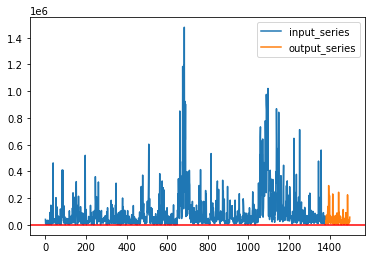

In [54]:
# sma3 가격 
plot_series(train_x_array[idx,:,-1], train_y_array[idx,:,-1]) 
plt.show()

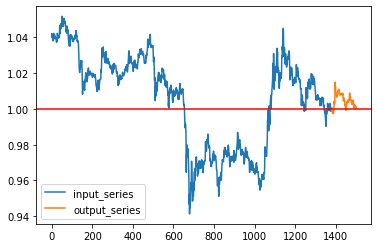

In [55]:
# open 가격 
plot_series(train_x_array[idx,:,1], train_y_array[idx,:,1]) # 1-4, open, high, low, close
plt.show()

# 3. 모델 훈련하기

## 1) train 샘플 훈련하기

In [56]:
# start_time = '2018-01-31 00:00:00'
# start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S')

In [57]:
idx = 4
# col_idx = -1 # sma3
col_idx = 1 # open 
x_series = train_x_array[idx,:,col_idx]
y_series = train_y_array[idx,:,col_idx]

In [58]:
start_time = '2016-01-31'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d')
start_dt

datetime.datetime(2016, 1, 31, 0, 0)

In [59]:
x_series.tolist()[:10]

[0.9545239210128784,
 0.953924298286438,
 0.95381897687912,
 0.9537050127983092,
 0.9547556042671204,
 0.95395028591156,
 0.9534522891044616,
 0.9531945586204528,
 0.953205704689026,
 0.9539453387260436]

In [60]:
import numpy as np 

x_df = pd.DataFrame()
x_df['ds'] = [start_dt + datetime.timedelta(days = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
x_df['y'] = x_series.tolist()
x_df.head()

,ds,y
0,2016-02-01,0.954524
1,2016-02-02,0.953924
2,2016-02-03,0.953819
3,2016-02-04,0.953705
4,2016-02-05,0.954756


In [61]:
# x_df = pd.DataFrame()
# x_df['ds'] = [start_dt + datetime.timedelta(minutes = time_min) for time_min in np.arange(1, x_series.shape[0]+1).tolist()]
# x_df['y'] = x_series.tolist()

In [62]:
len(x_df['ds']), len(x_df['y'])

(1380, 1380)

In [63]:
x_df.head()

,ds,y
0,2016-02-01,0.954524
1,2016-02-02,0.953924
2,2016-02-03,0.953819
3,2016-02-04,0.953705
4,2016-02-05,0.954756


In [64]:
# 파라미터 조정
scale = 0.03 # changepoint를 많이 잡도록 
width = 0.95
point_range = 1

In [65]:
# x_df['cap'] = 1.1
# x_df['floor'] = 0.5

In [66]:
prophet = Prophet( 
                  yearly_seasonality=True,
                  weekly_seasonality=True, 
                  daily_seasonality=True,
                  changepoint_prior_scale=scale, 
                  interval_width=width, 
                  changepoint_range=point_range,
                  # growth='logistic', # growth 추가
                  growth='linear',
                  seasonality_mode='multiplicative', # seasonality 추가 
                  seasonality_prior_scale=50.0 # seasonality scale 추가 
                  ) 
prophet.fit(x_df)

In [67]:
# 120분 테스트 데이터를 예측합니다.
future_data = prophet.make_future_dataframe(periods=10, freq='d')
# future_data['cap'] = 1.1
# future_data['floor'] = 0.5
forecast_data = prophet.predict(future_data)
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
1385,2019-11-17,0.998110,0.993287,1.002895
1386,2019-11-18,0.997766,0.993337,1.002391
1387,2019-11-19,0.997472,0.992679,1.002099
1388,2019-11-20,0.997011,0.992520,1.001886
1389,2019-11-21,0.996656,0.991657,1.001345


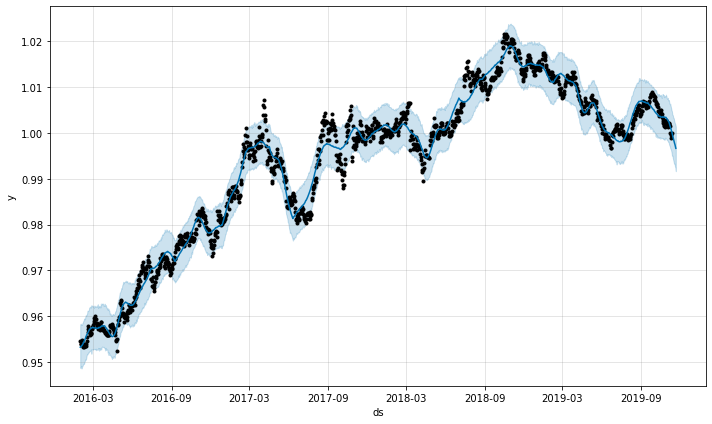

In [68]:
# 만들어진 데이터를 확인합니다.
fig1 = prophet.plot(forecast_data)

120 120 120


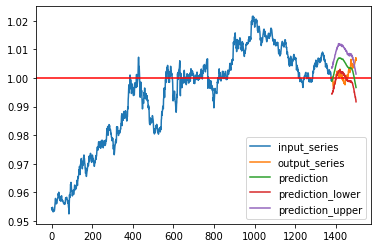

In [69]:
pred_y = forecast_data.yhat.values[-120:]
pred_y_lower = forecast_data.yhat_lower.values[-120:]
pred_y_upper = forecast_data.yhat_upper.values[-120:]

print(len(pred_y), len(pred_y_lower), len(pred_y_upper))

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
plt.plot(np.arange(1380, 1380+120), pred_y_lower, label = 'prediction_lower')
plt.plot(np.arange(1380, 1380+120), pred_y_upper, label = 'prediction_upper')
plt.legend()
plt.show()

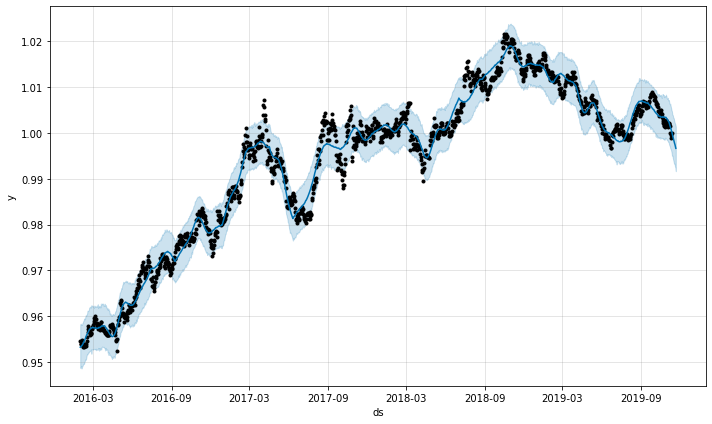

In [70]:
# 만들어진 데이터를 확인합니다.
fig1 = prophet.plot(forecast_data)

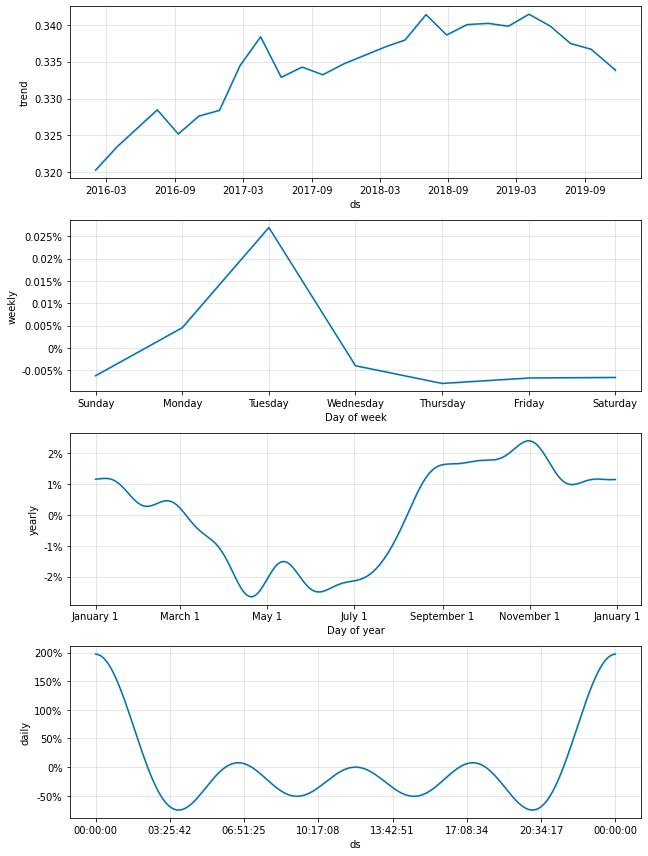

In [71]:
# 데이터의 추세를 확인합니다.
fig2 = prophet.plot_components(forecast_data)

120 120 120


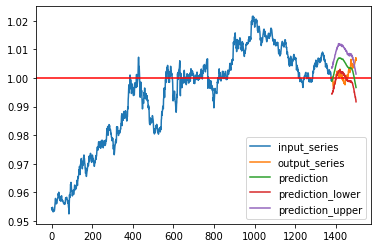

In [72]:
pred_y = forecast_data.yhat.values[-120:]
pred_y_lower = forecast_data.yhat_lower.values[-120:]
pred_y_upper = forecast_data.yhat_upper.values[-120:]

print(len(pred_y), len(pred_y_lower), len(pred_y_upper))

plot_series(x_series, y_series)
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
plt.plot(np.arange(1380, 1380+120), pred_y_lower, label = 'prediction_lower')
plt.plot(np.arange(1380, 1380+120), pred_y_upper, label = 'prediction_upper')
plt.legend()
plt.show()

## 2) validation set 훈련하기

### <1> validation 데이터 생성하기

In [73]:
# train 데이터 상단의 300개 샘플로 validation set를 구성하여 학습 및 추론
valid_x_df = train_x_df[train_x_df.sample_id < 300]
valid_y_df = train_y_df[train_y_df.sample_id < 300]

valid_x_array = df2d_to_array3d(valid_x_df)
valid_y_array = df2d_to_array3d(valid_y_df)
valid_pred_array = np.zeros([300, 120])

10 1380 300
Int64Index([255,  49,  51,  52,  53,  54,  55,  56,  57,  58,
            ...
            151, 153, 160, 154, 155, 156, 157, 158, 159,   0],
           dtype='int64', length=300)
10 120 300
Int64Index([287, 105, 169, 201, 233, 265, 297,  10,  42,  74,
            ...
            116, 180, 117, 212, 244, 276,  21,  53,  85,   0],
           dtype='int64', length=300)


In [74]:
print(len(valid_x_df), len(valid_y_df))
print(len(valid_x_array), len(valid_y_array), len(valid_pred_array))

414000 36000
300 300 300


### <2> 학습 및 추론하기

In [75]:
start_time = '2016-01-31'
start_dt = datetime.datetime.strptime(start_time, '%Y-%m-%d')
start_dt

datetime.datetime(2016, 1, 31, 0, 0)

In [76]:
for idx in tqdm(range(valid_x_array.shape[0])):
    try:
        x_series = valid_x_array[idx,:,col_idx] # col_idx: 해당하는 컬럼 번호 

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(days = time_day) for time_day in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet( 
                          yearly_seasonality=False,
                          weekly_seasonality=True, 
                          daily_seasonality=True,
                          changepoint_prior_scale=scale, 
                          interval_width=width, 
                          changepoint_range=point_range,
                          # growth='logistic', # growth 추가
                          growth='linear',
                          seasonality_mode='multiplicative', # seasonality 추가 
                          seasonality_prior_scale=50.0 # seasonality scale 추가 
                          ) 
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=10, freq='d')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        valid_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 300/300 [38:51<00:00,  7.77s/it]


### <3> valid_pred_array 로부터 buy_quantity, sell_time 구하기

In [77]:
valid_pred_array[idx,:] = pred_y_upper

In [78]:
def array_to_submission(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    sell = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
        
    buy_price = np.array(buy_price)
    # 115% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.05) * 1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [79]:
valid_submission = array_to_submission(valid_x_array, valid_pred_array)

In [80]:
valid_submission

,sample_id,buy_quantity,sell_time
0,0,0,53
1,1,0,0
2,2,0,0
3,3,0,52
4,4,0,54
...,...,...,...
295,295,0,119
296,296,0,0
297,297,0,0
298,298,0,58


In [81]:
valid_submission[valid_submission['sell_time']!=0]['sell_time']

0       53
3       52
4       54
6       54
7      119
      ... 
293      1
294    119
295    119
298     58
299    119
Name: sell_time, Length: 216, dtype: int64

In [82]:
# 전체 300가지 sample에 대해
# 5가지 case에서 105% 이상 상승한다고 추론함.
valid_submission.buy_quantity.value_counts()

0    295
1      5
Name: buy_quantity, dtype: int64

### <4> 투자 후 금액 계산하기

In [83]:
def df2d_to_answer(df_2d):
    # valid_y_df로부터
    # open 가격 정보가 포함된
    # [샘플 수, 120분] 크기의 
    # 2차원 array를 반환하는 함수
    feature_size = df_2d.iloc[:,2:].shape[1]
    time_size = len(df_2d.time.value_counts())
    sample_size = len(df_2d.sample_id.value_counts())
    sample_index = df_2d.sample_id.value_counts().index
    array_2d = df_2d.open.values.reshape([sample_size, time_size])
    sample_index = list(sample_index)
    return array_2d, sample_index


def COIN(y_df, submission, df2d_to_answer = df2d_to_answer):
    # 2차원 데이터프레임에서 open 시점 데이터만 추출하여 array로 복원
    # sample_id정보를 index에 저장
    y_array, index = df2d_to_answer(y_df)
    
    # index 기준으로 submission을 다시 선택
    submission = submission.set_index(submission.columns[0])
    submission = submission.iloc[index, :]    
    
    # 초기 투자 비용은 10000 달러
    total_momey      = 10000 # dolors
    total_momey_list = []
    
    # 가장 처음 sample_id값
    start_index = submission.index[0]
    for row_idx in submission.index:
        sell_time  = submission.loc[row_idx, 'sell_time']
        buy_price  = y_array[row_idx - start_index, 0]
        sell_price = y_array[row_idx - start_index, sell_time]
        buy_quantity = submission.loc[row_idx, 'buy_quantity'] * total_momey
        residual = total_momey - buy_quantity
        ratio = sell_price / buy_price
        total_momey = buy_quantity * ratio * 0.9995 * 0.9995 + residual        
        total_momey_list.append(total_momey)
        
    return total_momey, total_momey_list

In [84]:
total_momey, total_momey_list = COIN(valid_y_df,
                                     valid_submission)

In [85]:
# 투자 후 금액
print(total_momey)

9950.112350131176


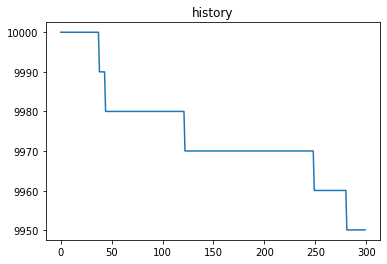

In [86]:
# 투자 히스토리
plt.plot(total_momey_list)
plt.title("history")
plt.show()

# 4. test 데이터 학습하고 추론하기

In [90]:
col_idx # open기준으로 학습

1

In [91]:
# 수행시간 30분 정도 걸림 
test_pred_array = np.zeros([test_x_array.shape[0],
                           120])

# 파라미터 조정
scale = 0.01 # 0.02에서 수정 
width = 0.95
point_range = 1

# shape 크기 만큼 학습을 반복
for idx in tqdm(range(test_x_array.shape[0])):
    try:
        x_series = test_x_array[idx,:,col_idx]

        x_df = pd.DataFrame()
        x_df['ds'] = [start_dt + datetime.timedelta(days = time_day) for time_day in np.arange(1, x_series.shape[0]+1).tolist()]
        x_df['y'] = x_series.tolist()

        prophet = Prophet( 
                          yearly_seasonality=False,
                          weekly_seasonality=True, 
                          daily_seasonality=False,
                          changepoint_prior_scale=scale, 
                          interval_width=width, 
                          changepoint_range=point_range,
                          # growth='logistic', # growth 추가
                          growth='linear',
                          seasonality_mode='multiplicative', # seasonality 추가 
                          seasonality_prior_scale=50.0 # seasonality scale 추가 
                          ) 
        prophet.fit(x_df)

        # 120분 테스트 데이터를 예측합니다.
        future_data = prophet.make_future_dataframe(periods=120, freq='d')
        forecast_data = prophet.predict(future_data)

        pred_y = forecast_data.yhat.values[-120:]
        pred_y_lower = forecast_data.yhat_lower.values[-120:]
        pred_y_upper = forecast_data.yhat_upper.values[-120:]

        test_pred_array[idx,:] = pred_y
    except:
        print(idx, " 샘플은 수렴하지 않습니다.")
        pass

100%|██████████| 529/529 [28:59<00:00,  3.29s/it]


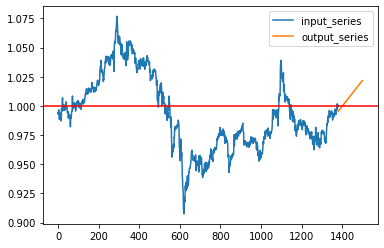

In [92]:
plot_series(x_series, pred_y) # y_series 없음 

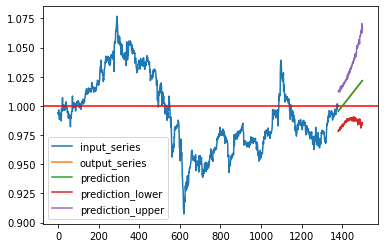

In [93]:
plot_series(x_series, pred_y) # y_series 없음 
plt.plot(np.arange(1380, 1380+120), pred_y, label = 'prediction')
plt.plot(np.arange(1380, 1380+120), pred_y_lower, label = 'prediction_lower')
plt.plot(np.arange(1380, 1380+120), pred_y_upper, label = 'prediction_upper')
plt.legend()
plt.show()

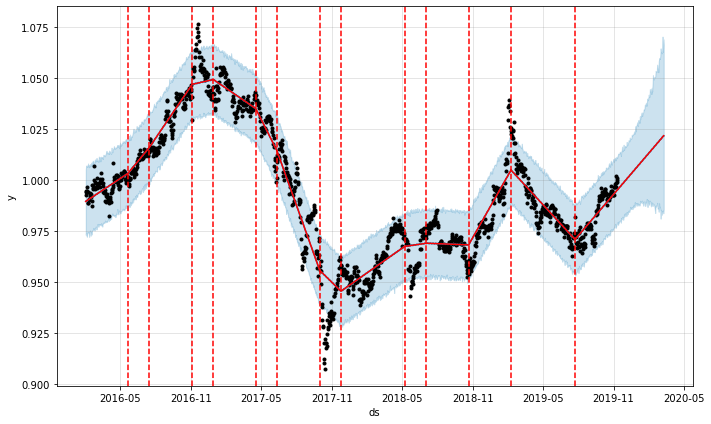

In [98]:
from fbprophet.plot import add_changepoints_to_plot


fig = prophet.plot(forecast_data)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast_data)

In [ ]:
def array_to_submission_using_macd(x_array, pred_array):
    # 입력 x_arrry와 출력 pred_arry를 통해서 
    # buy_quantitiy와 sell_time을 결정
    submission = pd.DataFrame(np.zeros([pred_array.shape[0],2], np.int64),
                columns = ['buy_quantity', 'sell_time'])
    submission = submission.reset_index()
    submission.loc[:, 'buy_quantity'] = 0.1
    
    buy_price = []
    sell = []
    for idx, sell_time in enumerate(np.argmax(pred_array, axis = 1)):
        buy_price.append(pred_array[idx, sell_time])
        
    buy_price = np.array(buy_price)
    # 115% 이상 상승한하고 예측한 sample에 대해서만 100% 매수
    submission.loc[:, 'buy_quantity'] = (buy_price > 1.05) * 1
    # 모델이 예측값 중 최대 값에 해당하는 시간에 매도
    submission['sell_time'] = np.argmax(pred_array, axis = 1)
    submission.columns = ['sample_id','buy_quantity', 'sell_time']
    return submission

In [198]:
# import numpy as np

# result_df = pd.DataFrame(series, columns=['open'])
# result_df.head()

,open
0,0.994208
1,0.994584
2,0.992628
3,0.996615
4,0.994734


In [95]:
submission = array_to_submission(test_x_array, test_pred_array)
# submission = array_to_submission_using_macd(test_x_array, test_pred_array)

In [96]:
# 전체 300가지 sample에 대해
# 5가지 case에서 105% 이상 상승한다고 추론함.
submission.buy_quantity.value_counts()

0    504
1     25
Name: buy_quantity, dtype: int64

In [97]:
import time

submission.to_csv(data_path+"/proh_scale={}_width={}_range={}_{}.csv".format(scale, width, point_range, time.strftime('%H%M%S')), index = False)